In [1]:
import numpy as np
import healpy as hp


# use the CAMB cosmology that generated the matter power spectra
import camb

import glass.ext.camb


import matplotlib
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')


In [2]:
from src.cosmology import nla, glass_utils, levin, parameters, priors
from src.cosmology.map_shears import map_shears
from src.cosmology.gower_street import GowerStCosmologies, GowerStDatasetBuilder
csv_path = '/home/asaoulis/projects/glass_transfer/kids-legacy-sbi/data/gower_st/PKDGRAV3_on_DiRAC_DES_330.csv'
gower_data_dir = '/share/gpu5/asaoulis/gowerstreet/'
gower_street_loader = GowerStDatasetBuilder(csv_path, gower_data_dir)
sim_num = 194

/home/asaoulis/projects/glass_transfer/src/cosmology/gower_street.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


## Setup some folders etc.

In [3]:
data_dir = '/home/asaoulis/projects/glass_transfer/kids-legacy-sbi/data'

### Define Cosmology Prior

In [40]:
kiyam_glass_cosmo_path = "/share/rcif2/klin/kids_legacy/sim-output/sobol_batch_1/cosmo_params/cosmo_params_1.txt"
# parse dict from file
import ast
with open(kiyam_glass_cosmo_path, 'r') as f:
    kiyam_glass_cosmo_params = ast.literal_eval(f.read())

In [41]:
# rename logT_ANG to logT_AGN
kiyam_glass_cosmo_params['logT_AGN'] = kiyam_glass_cosmo_params.pop('logT_ANG')
kiyam_glass_cosmo_params

{'h': 0.7696217058971524,
 'omch2': 0.20117915182560683,
 'ombh2': 0.025931960942223668,
 's8': 0.60323246428743,
 'w0': -1.0,
 'wa': 0.0,
 'ns': 0.8747998601943254,
 'a_ia': 5.179485759362579,
 'b_ia': 0.41527668774127957,
 'sigma8': 0.5335847987722588,
 'As': 5.268006052546293e-10,
 'Omega_c': 0.3396474491913831,
 'Omega_b': 0.0437805026347455,
 'Omega_m': 0.3834279518261286,
 'logT_AGN': 7.4036718217656015}

In [42]:
from src.cosmology.parameters import build_cosmology
cosmo, pars = build_cosmology(kiyam_glass_cosmo_params)

Note: redshifts have been re-sorted (earliest first)


In [43]:
nside = 1024
n_ell = 20
# lmax = 300
lmax = 2*nside
lmin = 0
omega_k = 0.0

# intrinsic alignments params
massdep_means = np.loadtxt(f'{data_dir}/priors/massdep_means.txt')
massdep_cov = np.loadtxt(f'{data_dir}/priors/massdep_cov.txt')
log10_M_eff_means = massdep_means[2:]
log10_M_eff_cov = massdep_cov[2:,2:] 
f_red = np.array([0.15, 0.2, 0.17, 0.24, 0.19, 0.03])
log10_M_eff = np.random.multivariate_normal(log10_M_eff_means, log10_M_eff_cov, size=1)[0]

logT_AGN_realised = kiyam_glass_cosmo_params['logT_AGN']
a_ia_realised     = kiyam_glass_cosmo_params['a_ia']
b_ia_realised     = kiyam_glass_cosmo_params['b_ia']

# intrinsic alignments params
ia_params = dict(
a_ia = a_ia_realised,
b_ia = b_ia_realised,
f_red = np.array([0.15, 0.2, 0.17, 0.24, 0.19, 0.03]),
log10_M_eff = log10_M_eff,
)


# Levin settings
levin_params = dict(
kmax=500.0,
kmin=1e10,
nmin=50,
npoint=3,
nmax=200
)

In [59]:
# basic parameters of the simulation
nside = 1024
n_ell = 20
# lmax = 300
lmax = 2*nside
lmin = 0
omega_k = 0.0
prior = {'s8': (0.5, 1.0),
            'h': (0.64, 0.82),
            'ns': (0.84, 1.1),
            'ombh2': (0.019, 0.026),
            'omch2': (0.051, 0.255),
            'w0': (-1.0, -1.0),
            'wa': (0.0, 0.0),
            'logT_AGN':(7.3, 8.3),
            'mnu': (0.06, 0.06),
            'a_ia': (4.48, 7.0),
            'b_ia': (0.28, 0.6),}
    
# intrinsic alignments params
massdep_means = np.loadtxt(f'{data_dir}/priors/massdep_means.txt')
massdep_cov = np.loadtxt(f'{data_dir}/priors/massdep_cov.txt')
log10_M_eff_means = massdep_means[2:]
log10_M_eff_cov = massdep_cov[2:,2:] 
f_red = np.array([0.15, 0.2, 0.17, 0.24, 0.19, 0.03])
log10_M_eff = np.random.multivariate_normal(log10_M_eff_means, log10_M_eff_cov, size=1)[0]

logT_AGN_realised = np.random.uniform(*prior['logT_AGN'])
a_ia_realised     = np.random.uniform(*prior['a_ia'])
b_ia_realised     = np.random.uniform(*prior['b_ia'])
nuisance_params = {"logT_AGN": logT_AGN_realised, "a_ia": a_ia_realised, "b_ia": b_ia_realised}

# intrinsic alignments params
ia_params = dict(
a_ia = a_ia_realised,
b_ia = b_ia_realised,
f_red = np.array([0.15, 0.2, 0.17, 0.24, 0.19, 0.03]),
log10_M_eff = log10_M_eff,
)


# Levin settings
levin_params = dict(
kmax=500.0,
kmin=1e10,
nmin=50,
npoint=3,
nmax=200
)
cosmo, pars, param_dict  = gower_street_loader.get_simulation_cosmology(sim_num, nuisance_params)



Note: redshifts have been re-sorted (earliest first)


In [44]:
#Get the result
results = camb.get_results(pars)
results.calc_power_spectra(pars)
k, z_grid, pk = results.get_nonlinear_matter_power_spectrum()
chi_grid = results.angular_diameter_distance(z_grid) * (1+z_grid) # the correpsonding comoving distances 
extended_k, extended_pk = levin.extrapolate_section(k, z_grid, pk, **levin_params)


In [45]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0.000, 3.1, dx=200.)
# ws, lp, ell = levin.setup_levin_power(zb, z_grid, chi_grid, extended_k, extended_pk, results, pars)

In [46]:
n_los_chi = 1000 #define the integration limits here
los_z_integration = np.linspace(zb[0], zb[-1], n_los_chi)
los_chi_integration = np.asarray(results.angular_diameter_distance(los_z_integration) * (1+los_z_integration) )

In [47]:
shift_nz = True # whether to shift the n(z) by the biases and covariance provided
# Instrinsic galaxy shape dispersion per tomographic bin
#Multiplicative shear bias
m_bias = np.array([-0.022869, -0.015966, -0.011331, 0.019870, 0.029506, 0.044535 ])
m_bias_unc = np.array([0.005630, 0.005900, 0.007111, 0.006773, 0.007598, 0.008902 ])

# Additive shear bias
c_1_bias_north = np.array([3.372, 8.941, 4.523, 4.722, 6.658, 4.224])*1e-4
c_1_bias_north_unc = np.array([1.528, 1.442, 1.747, 1.713, 1.887, 2.252])*1e-4
c_2_bias_north = np.array([7.941, 8.852, 4.533, 5.368, 5.532, 10.26])*1e-4
c_2_bias_north_unc = np.array([1.442, 1.642, 1.777, 1.665, 1.890, 2.400])*1e-4

c_1_bias_south = np.array([-3.398, -9.536, -4.755, -4.532, -6.117, -3.717])*1e-4
c_1_bias_south_unc = np.array([1.626, 1.519, 1.835, 1.653, 1.910, 2.151])*1e-4
c_2_bias_south = np.array([-8.002, -6.026, -4.766, -5.152, -5.082, -9.027])*1e-4
c_2_bias_south_unc = np.array([1.572, 1.590, 1.731, 1.594, 1.834, 2.282])*1e-4

# Galaxy density in each tomographic bin
n_arcmin2 = np.array([1.7698, 1.6494, 1.4974, 1.4578, 1.3451, 1.0682]) # per arcmin^2

# Instrinsic galaxy shape dispersion per tomographic bin
sigma_e = np.array([0.2772, 0.2716, 0.2899, 0.2619, 0.2802, 0.3002])


# Tomographic redshift bins
nbins = 6

ztomo = [
    (0.10, 0.42),
    (0.42, 0.58),
    (0.58, 0.71),
    (0.71, 0.90),
    (0.90, 1.14),
    (1.14, 2.00)
]

tomo_nz = np.zeros((nbins, n_los_chi))

ztomo_label = [
    ('0.10', '0.42'),
    ('0.42', '0.58'),
    ('0.58', '0.71'),
    ('0.71', '0.90'),
    ('0.90', '1.14'),
    ('1.14', '2.00')
]

if shift_nz:
    dz_biases = np.loadtxt(f'{data_dir}/nofzs/dz/Nz_biases.txt')
    dz_cov = np.loadtxt(f'{data_dir}/nofzs/dz/Nz_covariance.txt')
    shift_dz_realised = np.random.multivariate_normal(mean=dz_biases, cov=dz_cov, size=1)[0]
    

for i in range(nbins):
    hdu = np.loadtxt(f'{data_dir}/nofzs/nz/BLINDSHAPES_KIDS_Legacy_NS_shear_noSG_noWeiCut_newCut_blindABC_A1_rmcol_filt_lab_filt_lab_filt_PSF_RAD_calc_filt_ZB{str(ztomo_label[i][0]).split(".")[0]}p{str(ztomo_label[i][0]).split(".")[1]}t{str(ztomo_label[i][1]).split(".")[0]}p{str(ztomo_label[i][1]).split(".")[1]}_calib_goldwt_Nz.ascii').T
    z = hdu[0]
    if shift_nz:
        z_shifted = z - shift_dz_realised[i]
        n_z = np.interp(z, z_shifted, hdu[1])
        zmid = z[:-1] + 0.5*(z[1:] - z[:-1])
        dndz_interpolated = np.interp(los_z_integration, zmid, n_arcmin2[i]*n_z[:-1]/np.trapezoid((n_z[:-1]), zmid))
        tomo_nz[i] = np.clip(dndz_interpolated, 0, None)    
    else:
        zmid = z[:-1] + 0.5*(z[1:] - z[:-1])
        dndz_interpolated = np.interp(los_z_integration, zmid, n_arcmin2[i]*hdu[1][:-1]/np.trapezoid(hdu[1][:-1], zmid))
        tomo_nz[i] = np.clip(dndz_interpolated, 0, None)

# Read in the KiDS-Legacy mask
kids_mask = hp.read_map(f'{data_dir}/masks/KiDS_Legacy_N_healpix_1024_frac_withAstrom.fits') + hp.read_map(f'{data_dir}/masks/KiDS_Legacy_S_healpix_1024_frac_withAstrom.fits')
# vis = mask = hp.ud_grade(kids_mask, nside_out=nside, order_in='RING', order_out='RING', power=-2)
vis = mask = kids_mask


In [48]:
# Realised shear bias

m_bias_realised = np.array([float(np.random.normal(m_bias[i], m_bias_unc[i], 1)) for i in range(len(m_bias))])
c1_bias_north_realised = np.array([float(np.random.normal(c_1_bias_north[i], c_1_bias_north_unc[i], 1)) for i in range(len(c_1_bias_north))])
c2_bias_north_realised = np.array([float(np.random.normal(c_2_bias_north[i], c_2_bias_north_unc[i], 1)) for i in range(len(c_2_bias_north))])
c1_bias_south_realised = np.array([float(np.random.normal(c_1_bias_south[i], c_1_bias_south_unc[i], 1)) for i in range(len(c_1_bias_south))])
c2_bias_south_realised = np.array([float(np.random.normal(c_2_bias_south[i], c_2_bias_south_unc[i], 1)) for i in range(len(c_2_bias_south))])


/tmp/ipykernel_147491/3512286738.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_bias_realised = np.array([float(np.random.normal(m_bias[i], m_bias_unc[i], 1)) for i in range(len(m_bias))])
/tmp/ipykernel_147491/3512286738.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c1_bias_north_realised = np.array([float(np.random.normal(c_1_bias_north[i], c_1_bias_north_unc[i], 1)) for i in range(len(c_1_bias_north))])
/tmp/ipykernel_147491/3512286738.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this

In [49]:
rotation_angles=[0,]
num_shape_noise_realisations=1


In [50]:
# reload GlassLogNormalSimulator
import importlib
from src.cosmology import simulators
importlib.reload(simulators)

<module 'src.cosmology.simulators' from '/home/asaoulis/projects/glass_transfer/src/cosmology/simulators.py'>

In [51]:
SIMULATOR_TYPE = 'glass'
from src.cosmology.simulators import GlassLogNormalSimulator
import glass
kwargs = {
    'cosmo': cosmo,
    'los_z_integration': los_z_integration,
    'tomo_nz': tomo_nz,
    'galaxy_bias': 1.0,
    'shear_bias_params': {
        'm_bias': m_bias_realised,
        'c1_north': c1_bias_north_realised,
        'c2_north': c2_bias_north_realised,
        'c1_south': c1_bias_south_realised,
        'c2_south': c2_bias_south_realised
    },
    'nla_params': ia_params,
    'sigma_e': sigma_e,
    'mask': mask,
    'nside': nside,
    'nbins': nbins,
    'rng': np.random.default_rng()
}

if SIMULATOR_TYPE == 'glass':
    ws, lp, ell = levin.setup_levin_power(zb, z_grid, chi_grid, extended_k, extended_pk, results, pars)
    glass_cls, ws, n_glass_shells = glass_utils.compute_glass_cls(lp, ws, ell)
    glass_cls_discretized = glass.discretized_cls(glass_cls, nside=nside, lmax=lmax, ncorr=1)
    fields = glass.lognormal_fields(ws)
    gls = glass.solve_gaussian_spectra(fields, glass_cls_discretized)
    matter = glass.generate(fields, gls, nside, ncorr=1, rng=kwargs['rng'])
    simulator = GlassLogNormalSimulator(matter, ws, **kwargs)
elif SIMULATOR_TYPE == 'gower':
    simulator = gower_street_loader.setup_simulator(sim_num, **kwargs)

catalogues = simulator.run(rotation_angles=rotation_angles, num_shape_noise_realisations=num_shape_noise_realisations)


Computing angular power spectra...
Processing shell 1/28...


/home/asaoulis/projects/glass_transfer/src/cosmology/simulators.py:174: UserWarning: when sampling galaxies, redshifts_from_nz() is often not the function you want. Try redshifts() instead. Use warn=False to suppress this warning.
  gal_z = glass.galaxies.redshifts_from_nz(


Shell 1/28 processed in 32.32 seconds.
Processing shell 2/28...
Shell 2/28 processed in 32.56 seconds.
Processing shell 3/28...
Shell 3/28 processed in 33.74 seconds.
Processing shell 4/28...
Shell 4/28 processed in 32.89 seconds.
Processing shell 5/28...
Shell 5/28 processed in 32.89 seconds.
Processing shell 6/28...
Shell 6/28 processed in 32.52 seconds.
Processing shell 7/28...
Shell 7/28 processed in 32.92 seconds.
Processing shell 8/28...
Shell 8/28 processed in 32.79 seconds.
Processing shell 9/28...
Shell 9/28 processed in 32.97 seconds.
Processing shell 10/28...
Shell 10/28 processed in 34.05 seconds.
Processing shell 11/28...
Shell 11/28 processed in 35.53 seconds.
Processing shell 12/28...
Shell 12/28 processed in 36.26 seconds.
Processing shell 13/28...
Shell 13/28 processed in 35.28 seconds.
Processing shell 14/28...
Shell 14/28 processed in 34.58 seconds.
Processing shell 15/28...
Shell 15/28 processed in 34.96 seconds.
Processing shell 16/28...
Shell 16/28 processed in 34

In [43]:
catalogue = np.concatenate(catalogues[1])

In [33]:
from src.cosmology import map_shears
importlib.reload(map_shears)

<module 'src.cosmology.map_shears' from '/home/asaoulis/projects/glass_transfer/src/cosmology/map_shears.py'>

In [52]:
from pathlib import Path
import h5py
def save_results_h5(filename, cat_idx, cls_results, pixelised_results, cosmo_dict):
    filename = Path(filename)
    # if filename has no suffix, leave it; else keep extension:
    if filename.suffix == "":
        outname = filename.with_name(f"{filename.stem}_{cat_idx}")
    else:
        outname = filename.with_name(f"{filename.stem}_{cat_idx}{filename.suffix}")

    outdir = outname.parent
    outdir.mkdir(parents=True, exist_ok=True)

    def _save_dict(h5group, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                subgroup = h5group.create_group(str(key))
                _save_dict(subgroup, value)

            elif isinstance(value, str):
                dt = h5py.string_dtype(encoding="utf-8")
                h5group.create_dataset(str(key), data=value, dtype=dt)

            else:
                arr = np.asarray(value)

                # force cast object arrays to float64
                if arr.dtype == object:
                    try:
                        arr = arr.astype(np.float64)
                    except Exception as e:
                        raise TypeError(
                            f"Cannot cast key '{key}' to float64: {e}\nValue={value}"
                        )

                h5group.create_dataset(str(key), data=arr)


    with h5py.File(outname, "w") as f:
        _save_dict(f.create_group("cls_results"), cls_results)
        _save_dict(f.create_group("pixelised_results"), pixelised_results)
        _save_dict(f.create_group("cosmo_dict"), cosmo_dict)

    print(f"Results saved to {outname}")


In [53]:
from src.cosmology.manip_cls import denoise_shear_cls, unmix_shear_cl, cat2mask, maskcls, compute_cl_bandpowers
from src.cosmology.pixelise_maps import get_patch_values

from src.cosmology.map_shears  import make_alm_shear_convergence, filter_EB_alms_and_make_maps

def process_cls(catalogue, nbins, nside, alm, alm_rand, lower_lscale, upper_lscale, nbands):
    shear_cls_noiseless = denoise_shear_cls(nbins, alm, alm_rand, lmax)
    bin_masks = cat2mask(catalogue, nbins, nside)
    bin_mask_cls = maskcls(bin_masks, lmax=int(1.5*lmax), nbins=nbins)
    realised_unmixed_shear_cls = unmix_shear_cl(num_bins = nbins, shear_cls = shear_cls_noiseless, mask_cl = bin_mask_cls, lmin = lmin, lmax = lmax)
    realised_unmixed_shear_cls_cut = realised_unmixed_shear_cls[:, :, :, lower_lscale:upper_lscale+1]
    cll_bands, bandpowers = compute_cl_bandpowers(realised_unmixed_shear_cls_cut, nbins, lower_lscale, upper_lscale, nbands)
    return realised_unmixed_shear_cls, cll_bands, bandpowers

lower_lscale = 76
upper_lscale = 1500
nbands = 8
named_patches = {
    "south":(12, -31, 85, 11),     # (lon_center, lat_center, lon_range, lat_range)
    "north":(-178, 0, 112, 11)
}
patches = list(named_patches.values())
rotation_values = [rot for rot in rotation_angles for _ in range(num_shape_noise_realisations)]

for cat_idx, catalogue in enumerate(catalogues):
    catalogue = np.concatenate(catalogue)
    ang = rotation_values[cat_idx]
    cls_results = {cl_type:{} for cl_type in ['full', 'north', 'south']}

    alm, alm_rand, shear = make_alm_shear_convergence(
        catalogue, m_bias_realised, nbins, nside, lmax, nosh=False
    )

    E, B = filter_EB_alms_and_make_maps(
        alm_list=alm, nside_out=512, lmax_out=None, fwhm_arcmin=8.0, taper_start_frac=0.95
    )
    realised_unmixed_shear_cls, cll_bands, bandpowers = process_cls(catalogue, nbins, nside, alm, alm_rand, lower_lscale, upper_lscale, nbands, )
    # map_types = {"shear_real": shear.real, "shear_imag": shear.imag, "E":E, "B":B}
    map_types = {"E":E, "B":B}
    pixelised_results = {name:{} for name in map_types.keys()}
    for name, cat_data in map_types.items():
        pixelised_tomobin_patches = get_patch_values(cat_data, patches, 512, ang)
        for patch_idx, patch_name in enumerate(named_patches.keys()):
            pixelised_results[name][patch_name] = pixelised_tomobin_patches[patch_idx]


    cls_results['full'] = {"cls": realised_unmixed_shear_cls, "bandpowers":bandpowers, "bandpower_ls":cll_bands}

    # patch_defs = {
    #     "north": (np.abs(catalogue['DEC']) < 15),
    #     "south": (np.abs(catalogue['DEC']) >= 15),
    # }
    # for patch_name, selector in patch_defs.items():
    #     subcat = catalogue[selector]
    #     alm, alm_rand, _ = make_alm_shear_convergence(subcat, m_bias_realised, nbins, nside, lmax, nosh=False)
    #     realised_unmixed_shear_cls, cll_bands, bandpowers = process_cls(subcat, nbins, nside, alm, alm_rand, lower_lscale, upper_lscale, nbands, )
    #     cls_results[patch_name] = {"cls": realised_unmixed_shear_cls, "bandpowers":bandpowers, "bandpower_ls":cll_bands}

    save_results_h5(f"output_1_kiyam.h5", cat_idx, cls_results, pixelised_results, param_dict)

    

Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes


NameError: name 'param_dict' is not defined

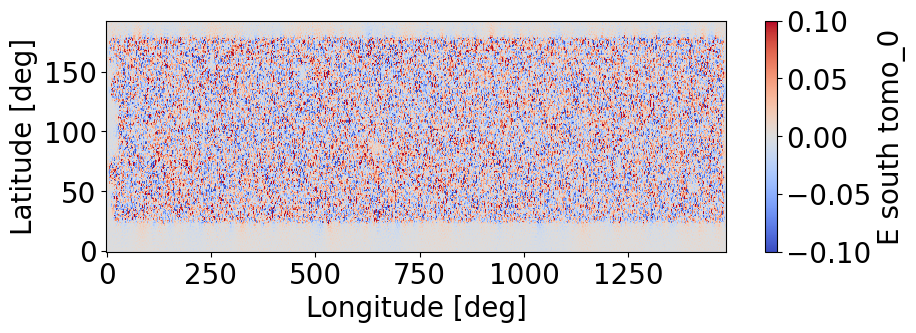

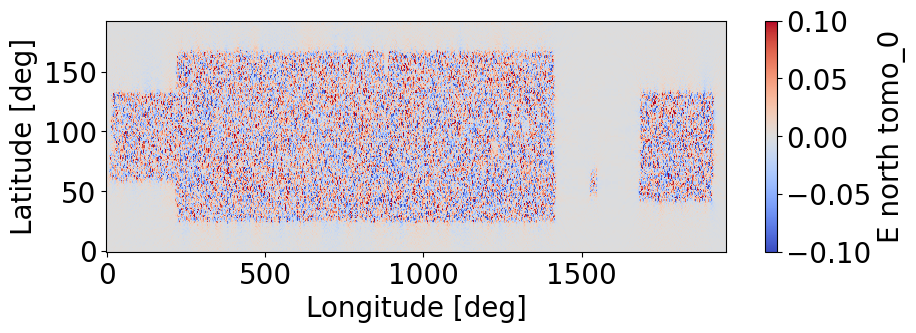

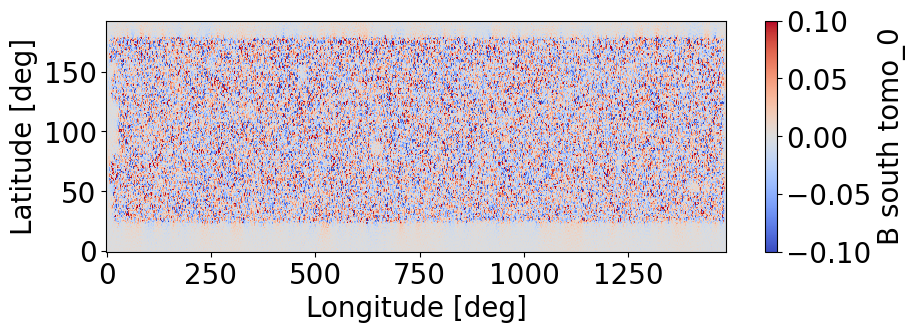

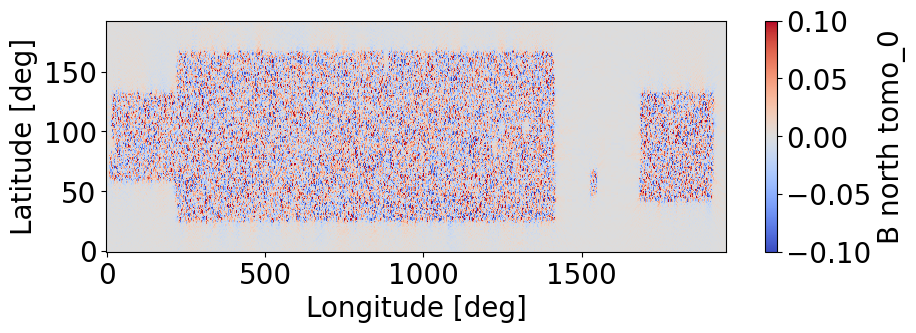

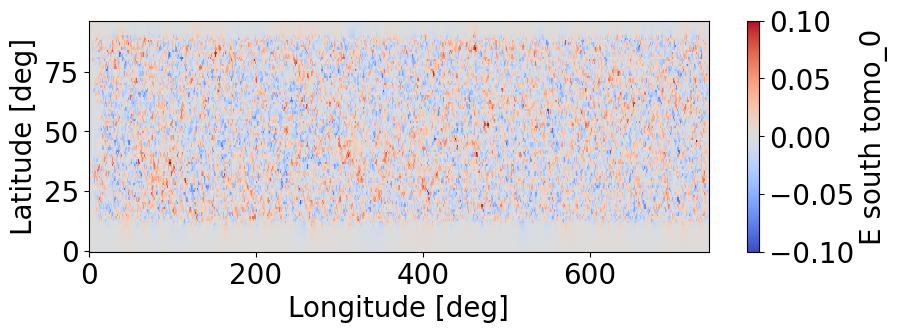

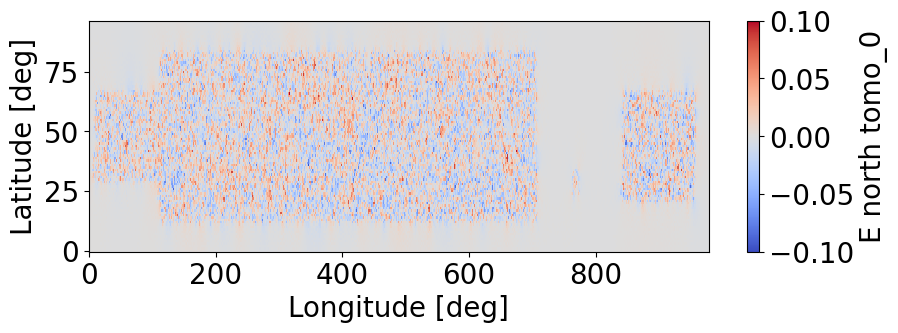

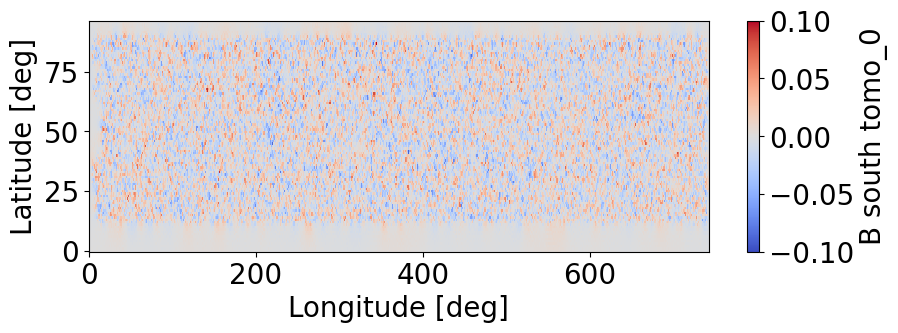

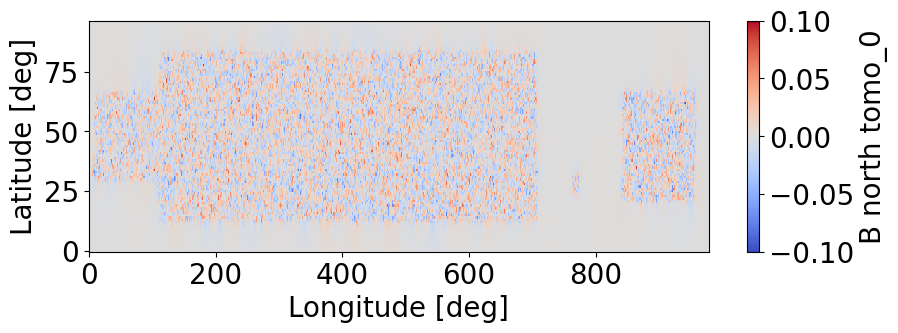

In [68]:
nside_out=nside
nbins = len(alm)
npix_out = hp.nside2npix(nside_out)
E_maps_out = np.zeros((nbins, npix_out), dtype=float)
B_maps_out = np.zeros((nbins, npix_out), dtype=float)

for i, (almE, almB) in enumerate(alm):
    # Synthesize directly at target resolution and bandlimit
    E_maps_out[i] = hp.alm2map(almE, nside=nside_out)
    B_maps_out[i] = hp.alm2map(almB, nside=nside_out)
map_types = {"E":E_maps_out, "B":B_maps_out}
pixelised_results = {name:{} for name in map_types.keys()}
for name, cat_data in map_types.items():
    pixelised_tomobin_patches = get_patch_values(cat_data, patches, nside, ang)
    for patch_idx, patch_name in enumerate(named_patches.keys()):
        pixelised_results[name][patch_name] = pixelised_tomobin_patches[patch_idx]

def plot_patch(values, label):
    plt.figure(figsize=(10, 3))
    plt.imshow(values[::-1, ::-1],
               origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1, aspect="auto")
    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.colorbar(label=f"{label}")
    plt.show()

for field_type, field_dict in pixelised_results.items():
    for patch_name, values in field_dict.items():
        plot_patch(values[0],f"{field_type} {patch_name} tomo_0" )

E, B = filter_EB_alms_and_make_maps(
    alm_list=alm, nside_out=512, lmax_out=None, fwhm_arcmin=8.0, taper_start_frac=0.95
)
map_types = {"E":E, "B":B}
pixelised_results = {name:{} for name in map_types.keys()}
for name, cat_data in map_types.items():
    pixelised_tomobin_patches = get_patch_values(cat_data, patches, 512, ang)
    for patch_idx, patch_name in enumerate(named_patches.keys()):
        pixelised_results[name][patch_name] = pixelised_tomobin_patches[patch_idx]
for field_type, field_dict in pixelised_results.items():
    for patch_name, values in field_dict.items():
        plot_patch(values[0],f"{field_type} {patch_name} tomo_0" )


In [61]:
cls_results.keys()

dict_keys(['full', 'north', 'south'])

In [ ]:
path = './output_194_0.h5'
with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    print(f['cls_results']['north'].keys())
    cls = f['cls_results']['full']['bandpowers'][:]
    data = f['pixelised_results']['E']['north'][:]
    print(f['cosmo_dict'].keys())
    print(f['cosmo_dict']['omega_m'][()])
    cl_results = 


['cls_results', 'cosmo_dict', 'pixelised_results']
<KeysViewHDF5 ['bandpower_ls', 'bandpowers', 'cls']>
<KeysViewHDF5 ['a_ia', 'b_ia', 'h', 'logT_AGN', 'mnu', 'ns', 'ombh2', 'omega_m', 's8', 'w0']>
0.2492599973


In [21]:
kiyam_glass_bandpowers_path = "/share/rcif2/klin/kids_legacy/sim-output/sobol_batch_1/bandpowers/bandpowers_1.npy"
bandpowers_kiyam = np.load(kiyam_glass_bandpowers_path)

In [23]:
bandpowers_kiyam.shape

(21, 8)

full


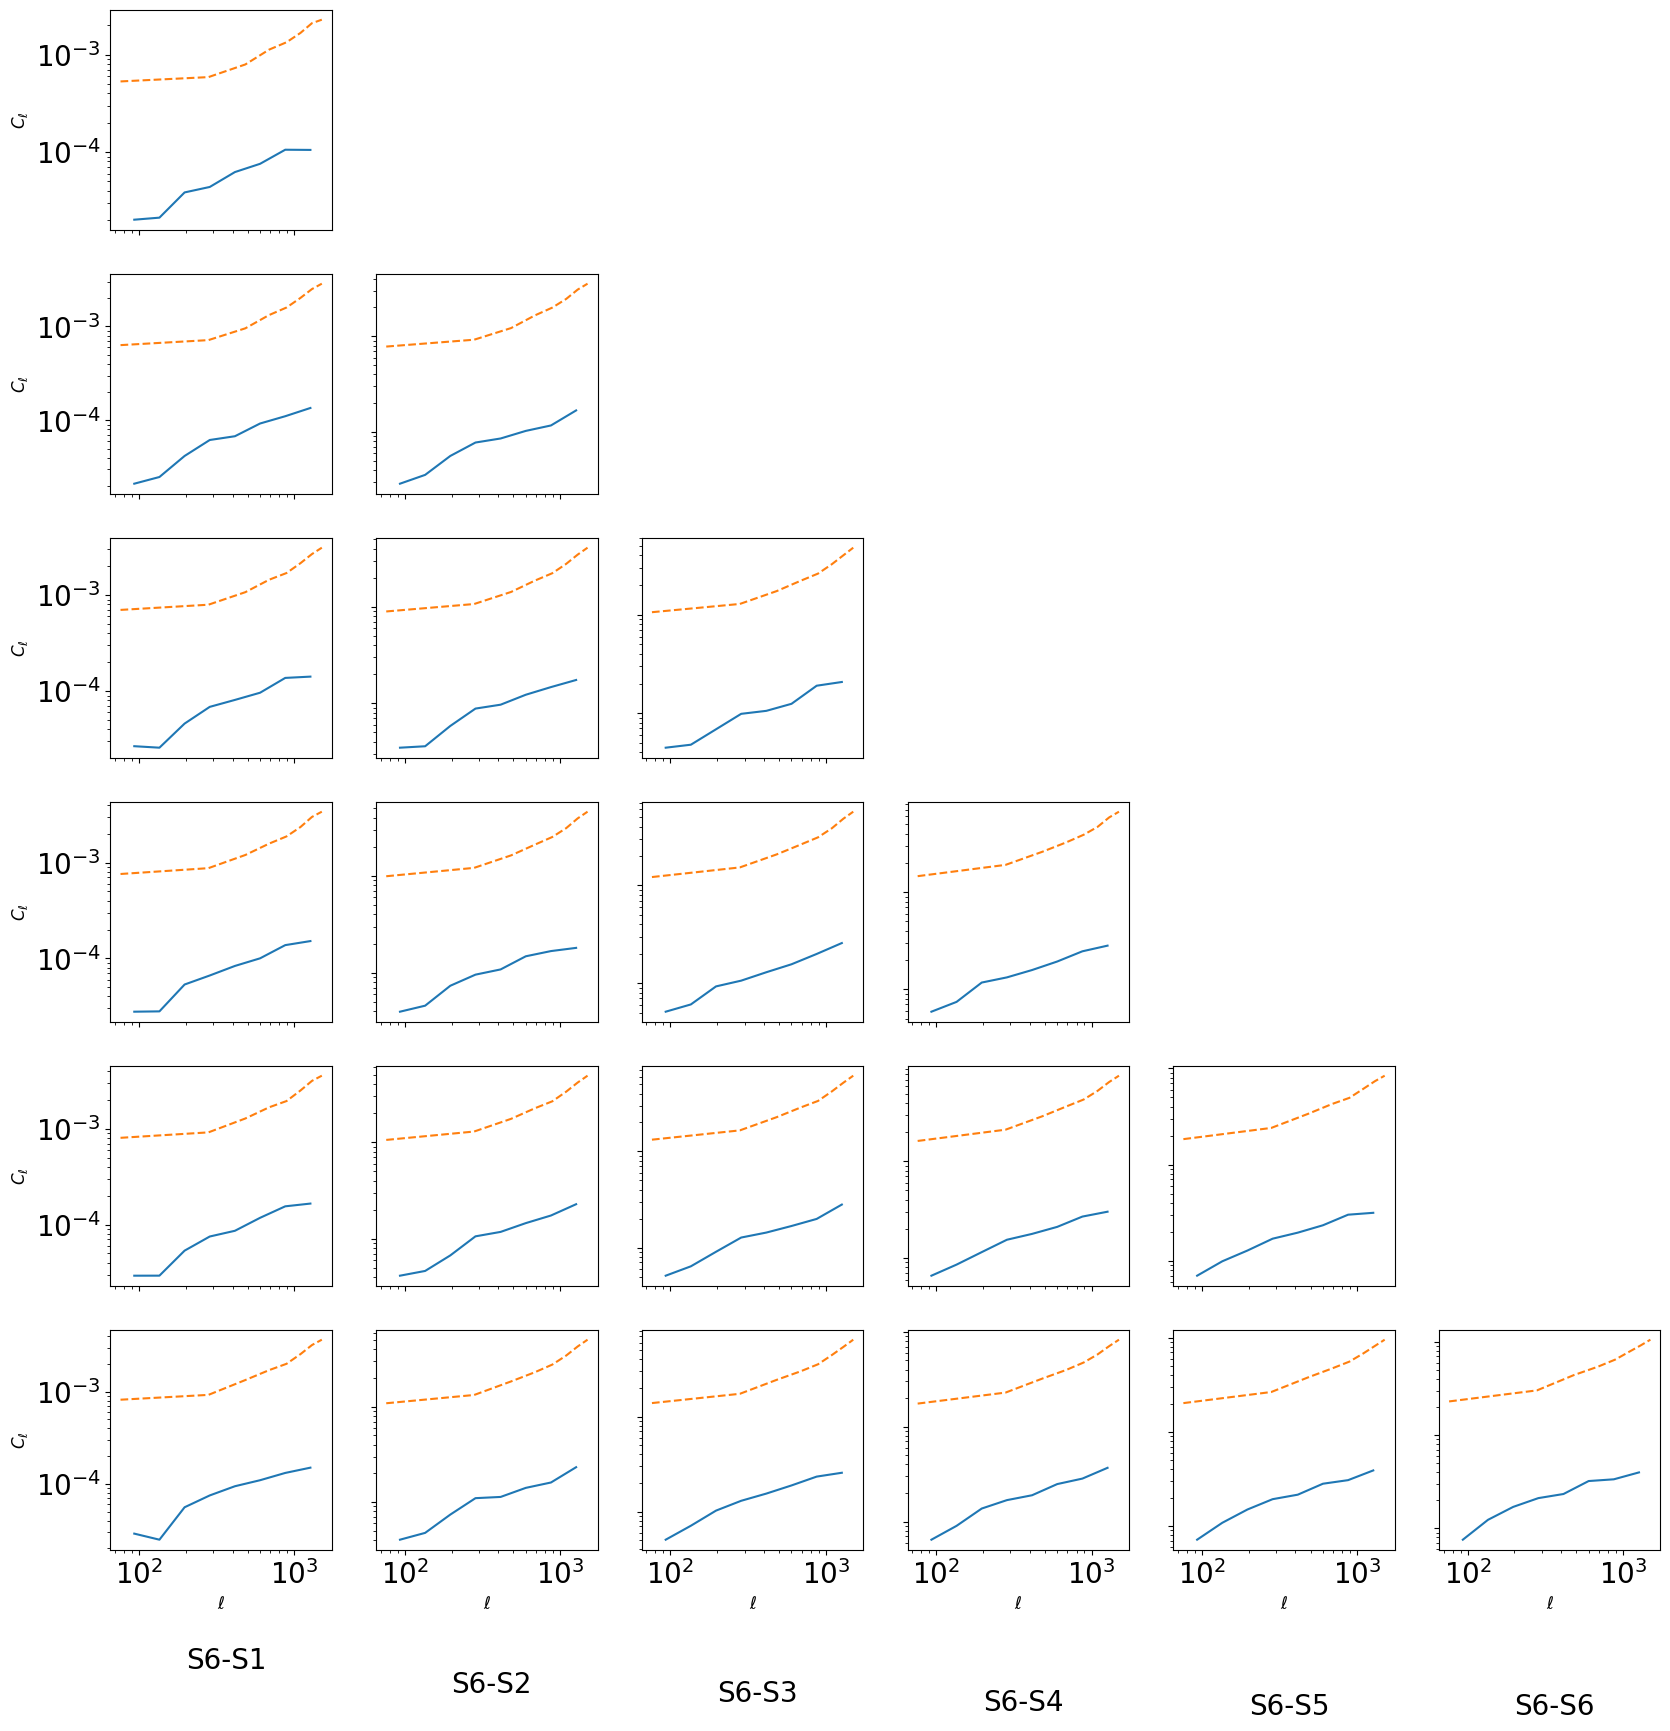

north


KeyError: 'bandpower_ls'

In [54]:
for cl_type, cl_results in cls_results.items():
    print(cl_type)
    cll_bands = cl_results['bandpower_ls']
    num_kiyam_bands = bandpowers_kiyam.shape[1]
    interped_cll_bands = np.linspace(lower_lscale, upper_lscale+1, num_kiyam_bands)
    bandpowers = cl_results["bandpowers"]
    fig, ax = plt.subplots(nbins, nbins, figsize=(20,20))
    for i in range(nbins):
        for j in range(nbins):
            if i<j:
                ax[i, j].axis('off')
            else:
                label = 'S'+str(i+1)+'-S'+str(j+1)
                ax[i, j].plot(cll_bands, bandpowers[int(i*(i+1)/2 + j)], label=label)
                if cl_type == 'full':
                    ax[i, j].plot(interped_cll_bands, bandpowers_kiyam[int(i*(i+1)/2 + j)], label='Kiyam et al. 2024', linestyle='dashed')
                ax[i, j].set_xscale('log')
                ax[i, j].set_yscale('log')
                # ax[i, j].set_xlim([lower_lscale, upper_lscale])
                # ax[i, j].set_ylim([5e-14, 5e-6])
                ax[i, j].text(200, 1e-6, label)

                if i == nbins - 1:
                    ax[i, j].set_xlabel(r'$\ell$', fontsize=12)
                else:
                    plt.setp(ax[i, j].get_xticklabels(), visible=False)
                
                if j == 0:
                    ax[i, j].set_ylabel(r'$C_{\ell}$', fontsize=12)
                else:
                    plt.setp(ax[i, j].get_yticklabels(), visible=False)
    plt.show()

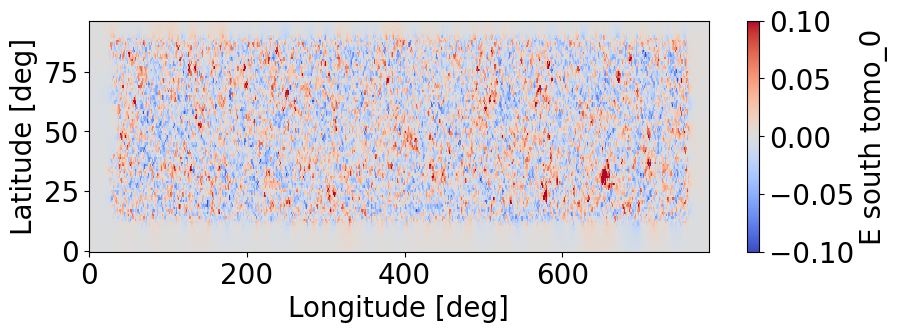

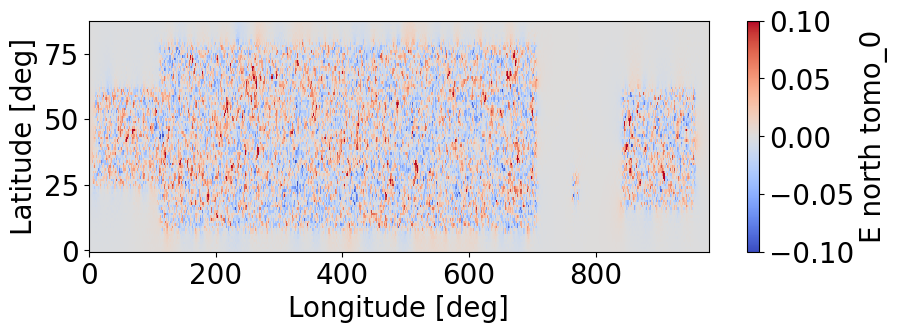

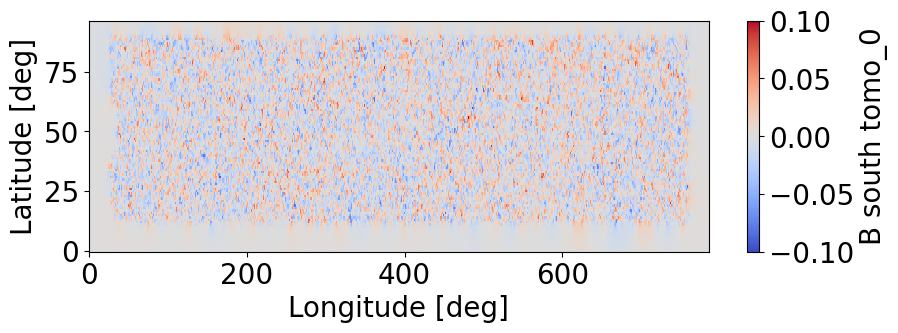

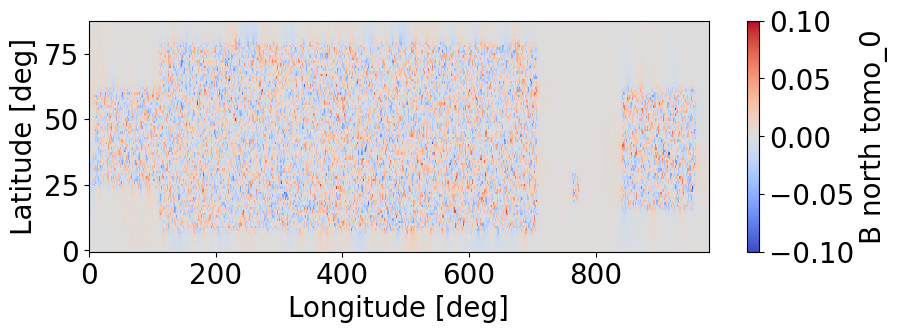

In [62]:
def plot_patch(values, label):
    plt.figure(figsize=(10, 3))
    plt.imshow(values[::-1, ::-1],
               origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1, aspect="auto")
    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.colorbar(label=f"{label}")
    plt.show()

for field_type, field_dict in pixelised_results.items():
    for patch_name, values in field_dict.items():
        plot_patch(values[0],f"{field_type} {patch_name} tomo_0" )

In [46]:
rotation_angles

[0, 180]

In [94]:
ARCMIN2_SPHERE

148510660.49790937

In [101]:
ntot

np.float64(3720098.751492553)

In [109]:
# Assumes: nbins, lmax, nside, n_arcmin2 (array len nbins), catalogue (structured array),
# and ARCMIN2_SPHERE, arcmin2_to_sr already set.

npix = hp.nside2npix(nside)
ell = np.arange(lmax + 1)

# compute per-bin total galaxy counts either from catalogue (preferred) or from n_arcmin2:
use_catalogue_counts = True   # set False to force use of n_arcmin2 * ARCMIN2_SPHERE

Ntot = np.zeros(nbins, dtype=float)
for i in range(nbins):
    if use_catalogue_counts:
        Ntot[i] = np.sum(catalogue['ZBIN'] == i)   # actual number of galaxies in that bin
    else:
        Ntot[i] = n_arcmin2[i] * ARCMIN2_SPHERE

# prepare identity and ell-term
I = np.eye(lmax + 1)
ell_term = (ell + 0.5)   # matches your previous (ell + 1/2)

# function that builds auto mm
def build_mm_auto(N):
    if N <= 1:
        # degeneracy guard: if a bin has <=1 galaxy don't try this analytic form
        mm = np.zeros((lmax + 1, lmax + 1))
        mm[2:, 2:] = 0.0
        return mm
    mm = (1.0 - 1.0 / N) * I + np.outer(ell_term, np.ones(lmax + 1)) / N
    # set monopole/dipole rows/cols to zero if that's your convention
    mm[:2, :] = 0.0
    mm[:, :2] = 0.0
    return mm

# build a dictionary of mixing matrices for every pair (i,j)
mixing_matrices = {}
for i in range(nbins):
    for j in range(i+1):
        if i == j:
            mixing_matrices[(i, j)] = build_mm_auto(Ntot[i])
            mixing_matrices[(j, i)] = mixing_matrices[(i, j)]
        else:
            # default: no shot-noise cross term (identity)
            mm_cross = I.copy()
            mm_cross[:2, :] = 0.0
            mm_cross[:, :2] = 0.0

            # Optional: if the same galaxy can appear in both bins, estimate overlap and insert small term.
            # Overlap_count = number of objects that are in both bins (often zero for strict tomographic bins).
            overlap_count = np.sum((catalogue['ZBIN'] == i) & (catalogue['ZBIN'] == j))
            if overlap_count > 0:
                # approximate cross-mixing ~ (ell + 0.5) / N_overlap
                mm_cross += np.outer(ell_term, np.ones(lmax + 1)) / float(overlap_count)
            mixing_matrices[(i, j)] = mm_cross
            mixing_matrices[(j, i)] = mm_cross


In [114]:
# correct total sphere area in arcmin^2 (float division)
ARCMIN2_SPHERE = 60**6 / 100 / np.pi

npix = hp.nside2npix(nside)   # safer than 12*nside**2

# per-ℓ precompute
ell = np.arange(lmax + 1)
fl = (ell + 2)*(ell + 1)*ell*(ell - 1) / np.clip(ell**2 * (ell + 1)**2, 1, None)
pw, pw2 = hp.pixwin(nside, lmax=lmax, pol=True)

mms = []

for i in range(nbins):
    # galaxies per pixel
    arcmin2_per_pixel = ARCMIN2_SPHERE / npix
    n_gal_per_pixel = arcmin2_per_pixel * n_arcmin2[i]   # gal per pixel

    # total galaxies implied
    ntot = n_gal_per_pixel * npix   # should equal n_arcmin2[i] * ARCMIN2_SPHERE

    # mixing matrix using ntot (float)
    mm = (1.0 - 1.0 / ntot) * np.eye(lmax + 1) + (ell + 0.5) / ntot
    mm[:2, :] = mm[:, :2] = 0

    mms.append(mm)


In [115]:
pw, pw2

(array([1.        , 0.99999995, 0.99999984, ..., 0.82759132, 0.82743558,
        0.8272798 ], shape=(2049,), dtype='>f8'),
 array([0.        , 0.        , 0.99999991, ..., 0.82759138, 0.82743565,
        0.82727986], shape=(2049,), dtype='>f8'))

In [82]:
# get the theory cls from CAMB
pars.NonLinear = "NonLinear_both"
pars.Want_CMB = False
pars.min_l = 2
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=los_z_integration, W=tomo_nz[i], source_type="lensing") for i in range(len(tomo_nz))

]
results = camb.get_results(pars)
theory_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

In [57]:
kiyam_glass_cls_path = "/share/rcif2/klin/kids_legacy/sim-output/sobol_batch_1/uncut_shear_cls/uncut_realised_unmixed_shear_cls_1.npy"
cls_kiyam = np.load(kiyam_glass_cls_path, allow_pickle=True)

In [58]:
cls_kiyam.shape

(6, 6, 3, 2049)

In [89]:
realised_unmixed_shear_cls.shape

(6, 6, 3, 2049)

full


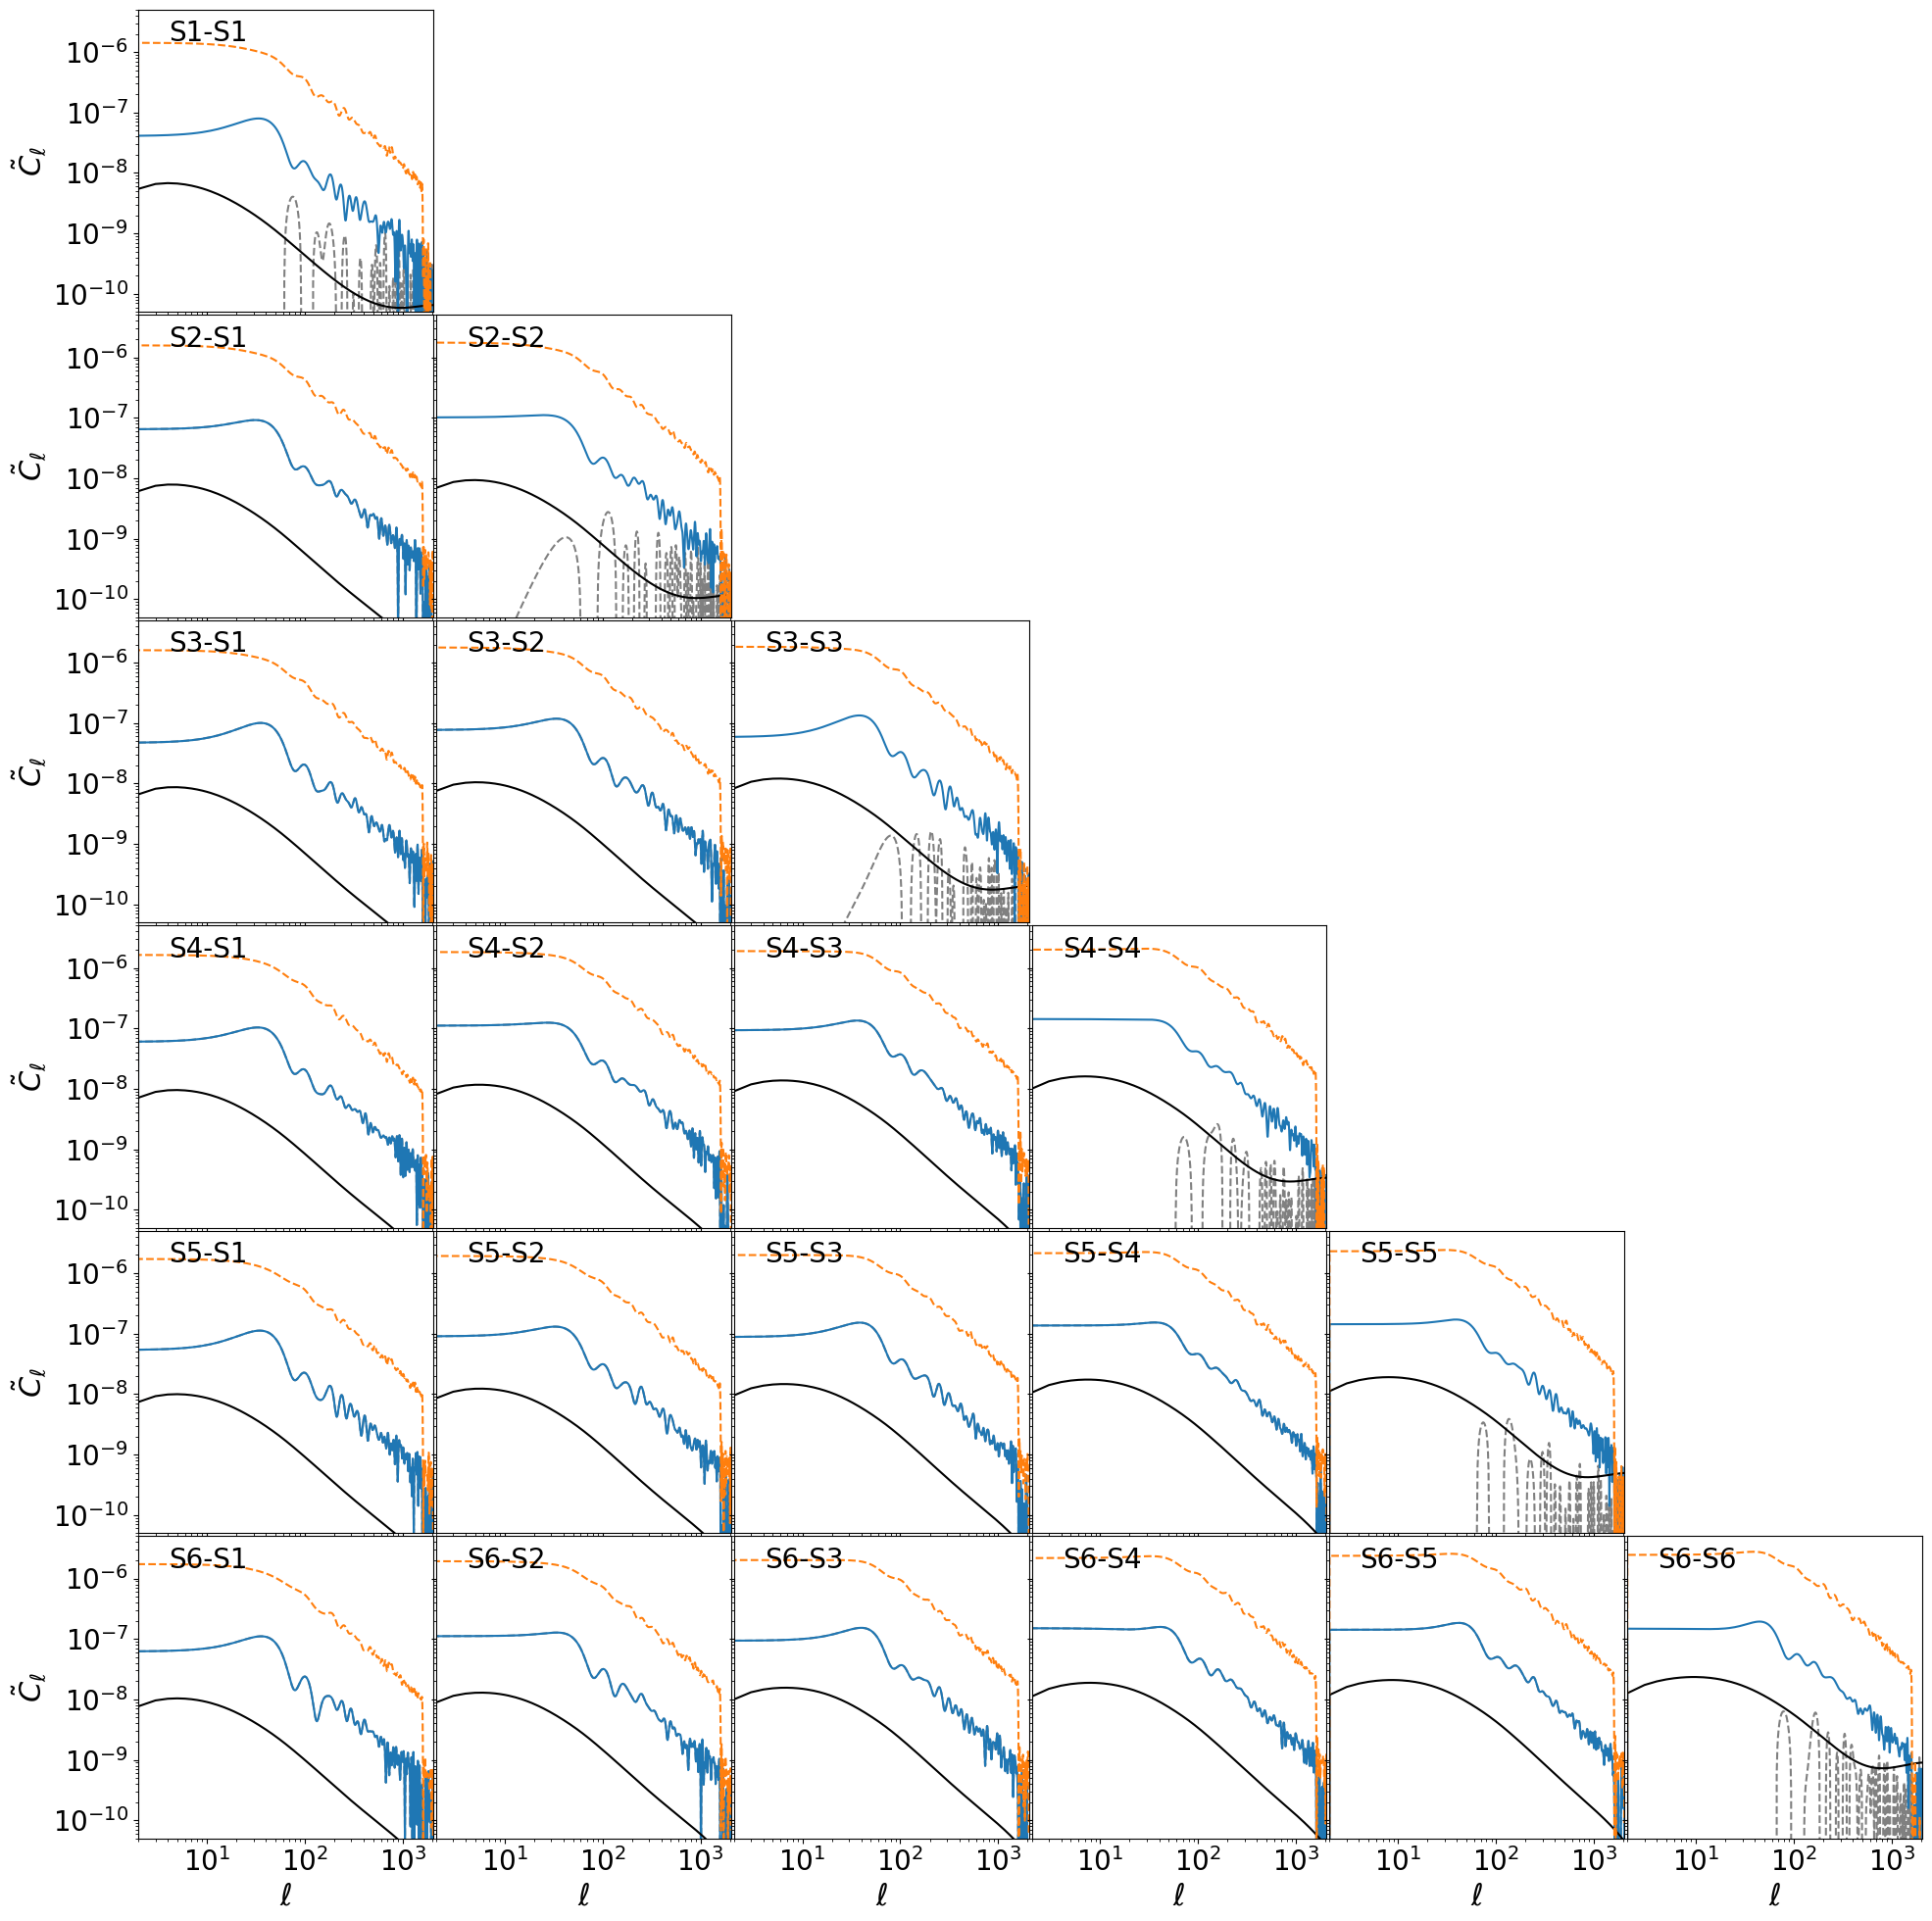

KeyError: 'cls'

In [116]:
matplotlib.rcParams.update({'font.size': 20})
for cl_type, cl_results in cls_results.items():
    realised_unmixed_shear_cls = cl_results['cls']
    print(cl_type)
    counter=0
    fig, axs = plt.subplots(nbins, nbins, figsize=(20, 20))
    xmin, xmax = 2, lmax
    ymin, ymax = 5e-11, 5e-6

    for i in range(0, nbins):
        for j in range(0, nbins):
            if i<j:
                axs[i, j].axis('off')
            else:
                x = 10**(np.log10(xmin)) + 0.7*(np.log10(xmax) - np.log10(xmin))
                y = ymin + 0.3*(ymax - ymin)

                axs[i, j].plot(np.arange(0, lmax+1), realised_unmixed_shear_cls[i][j][2], c='grey', ls = '--')
                axs[i, j].plot(np.arange(0, lmax+1), realised_unmixed_shear_cls[i][j][0], c='C0')
                    # theory_cls_kappa_ij is a length-(lmax+1) array (C_κκ for bins i,j)
                predicted_shear_cl_EE_ij = pw**2 * (mixing_matrices[(i,j)] @ (fl * theory_cls[f'W{i+1}xW{j+1}']))

                axs[i, j].plot(np.arange(0, lmax+1), predicted_shear_cl_EE_ij, c='black')
                if cl_type == 'full':
                    axs[i, j].plot(np.arange(0, lmax+1), cls_kiyam[i][j][0], c='C1', ls='dashed')

                axs[i, j].set_xscale('log')
                axs[i, j].set_yscale('log')
                axs[i, j].set_xlim([xmin, xmax])
                axs[i, j].set_ylim([ymin, ymax])
                label = 'S'+str(i+1)+'-S'+str(j+1)
                axs[i, j].text(x, y, label)

                if i == nbins - 1:
                    axs[i, j].set_xlabel(r'$\ell$', fontsize=22)
                else:
                    plt.setp(axs[i, j].get_xticklabels(), visible=False)
                
                if j == 0:
                    axs[i, j].set_ylabel(r'$\tilde{C}_{\ell}$', fontsize=22)
                else:
                    plt.setp(axs[i, j].get_yticklabels(), visible=False)

                counter += 1

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

full


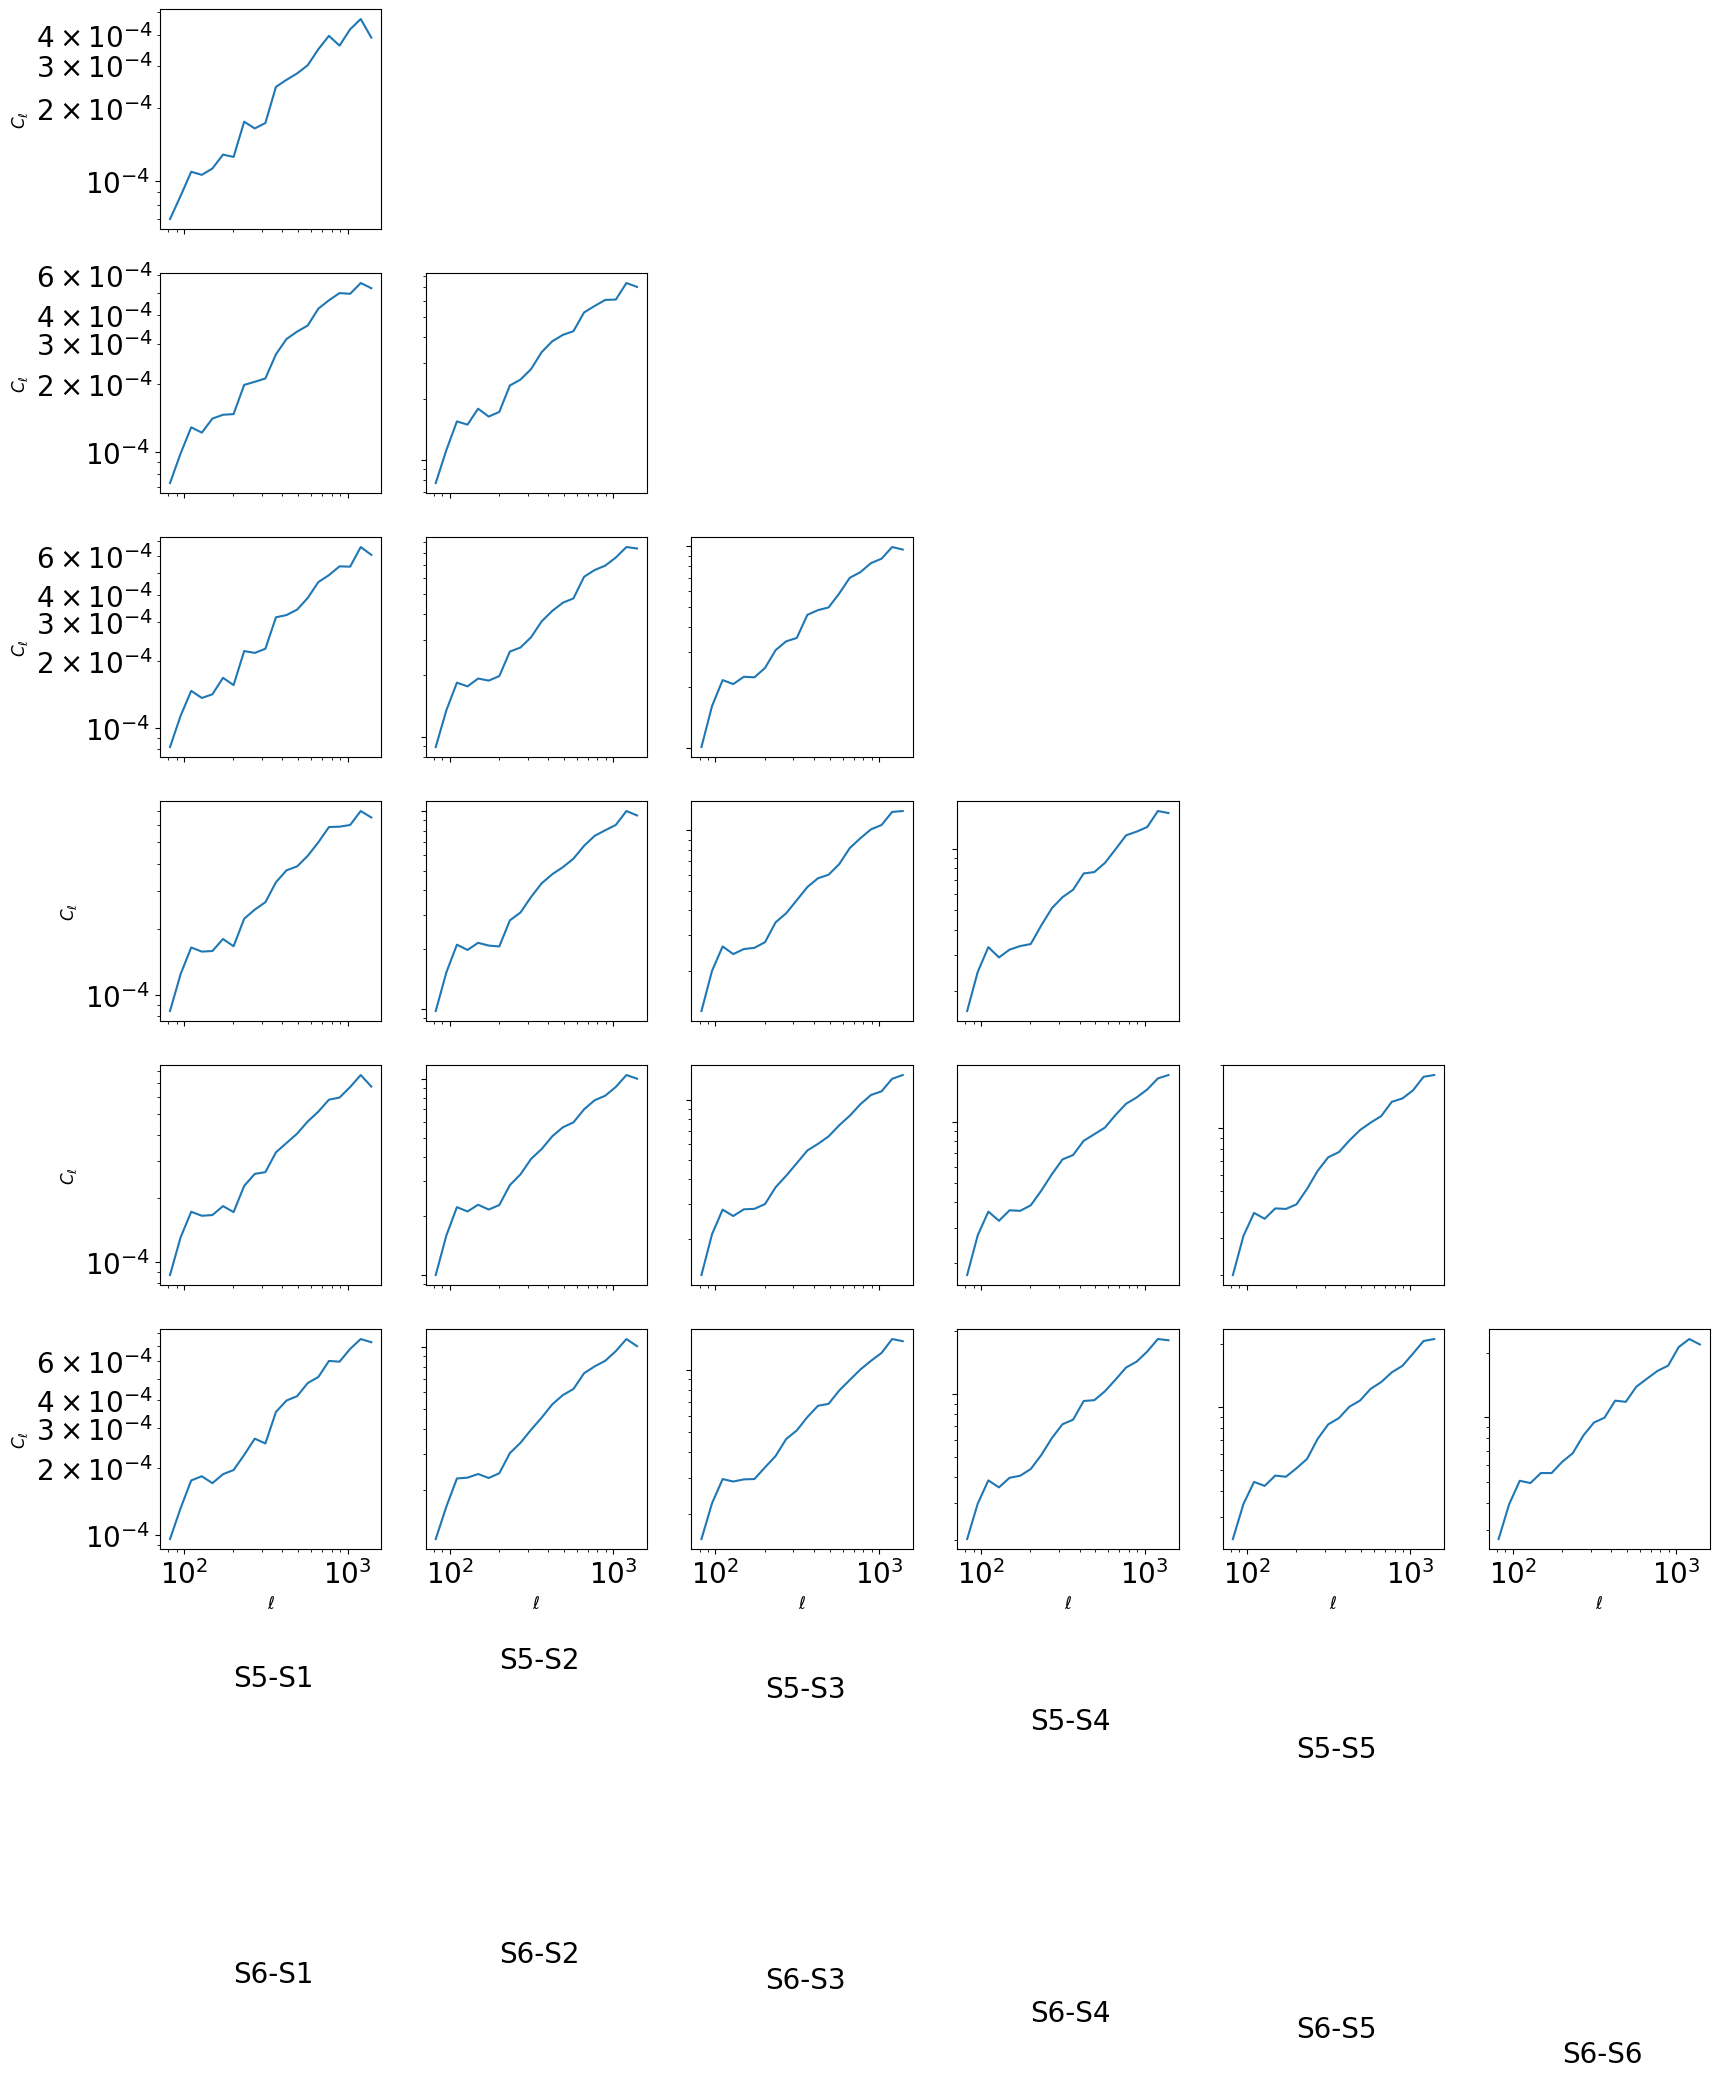

north


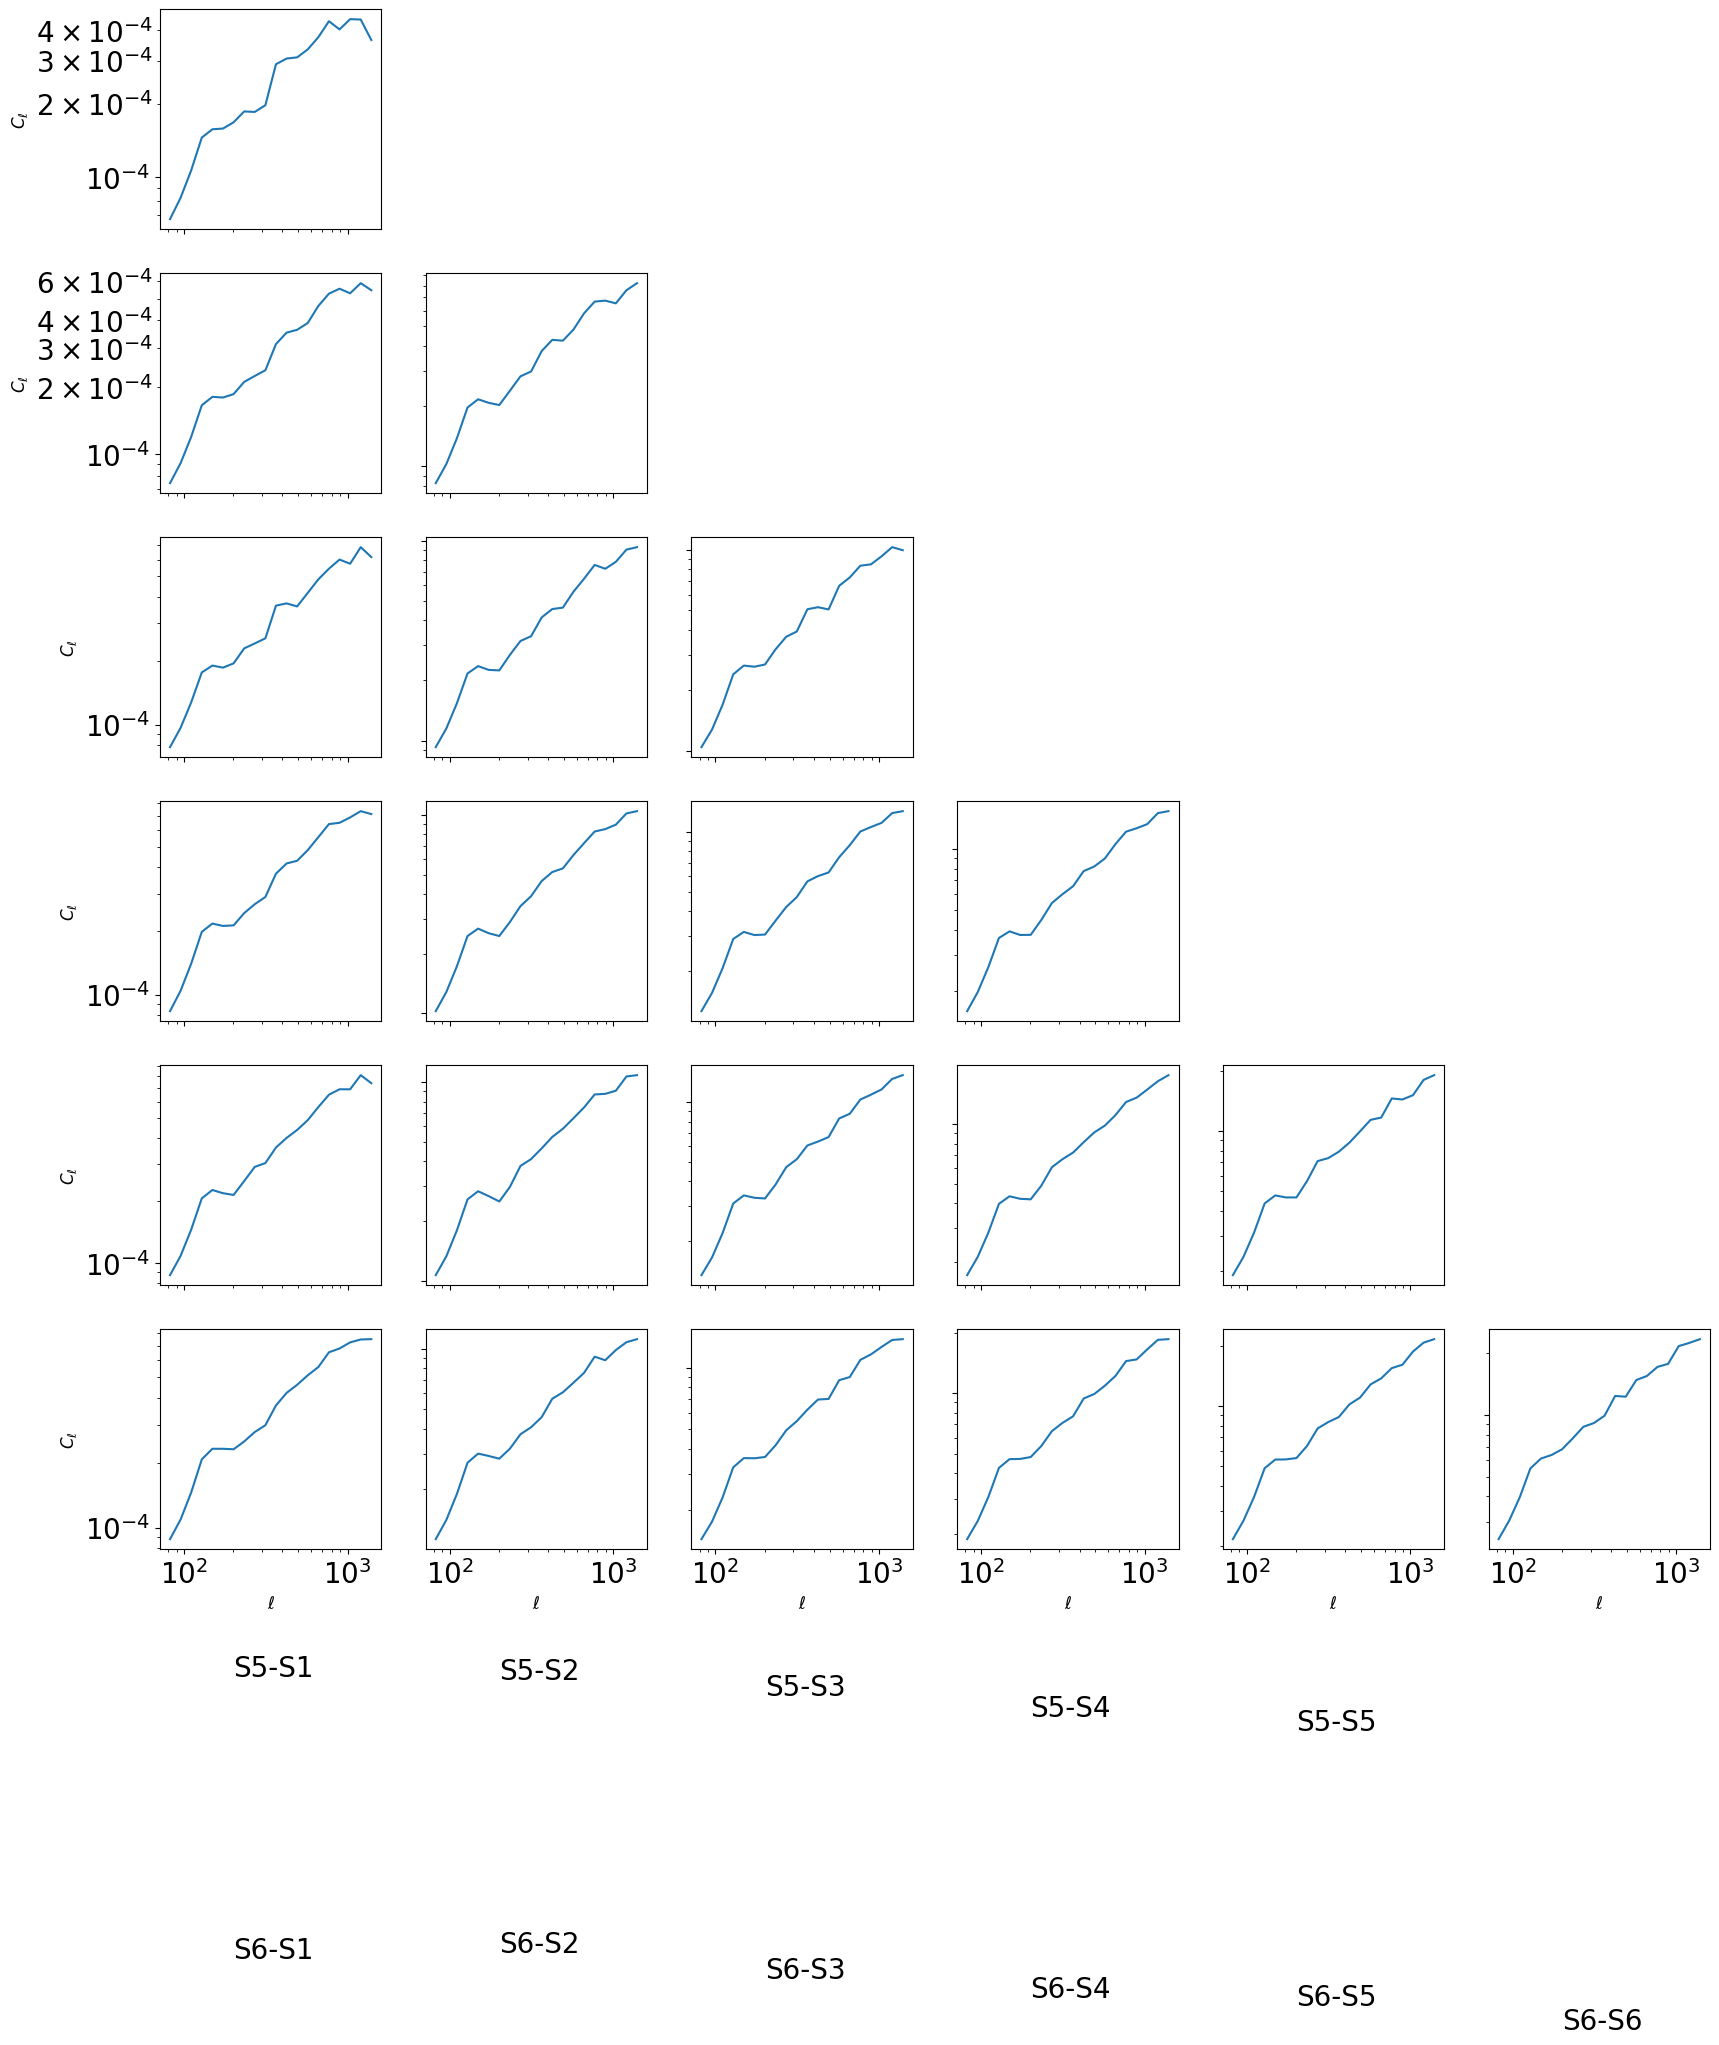

south


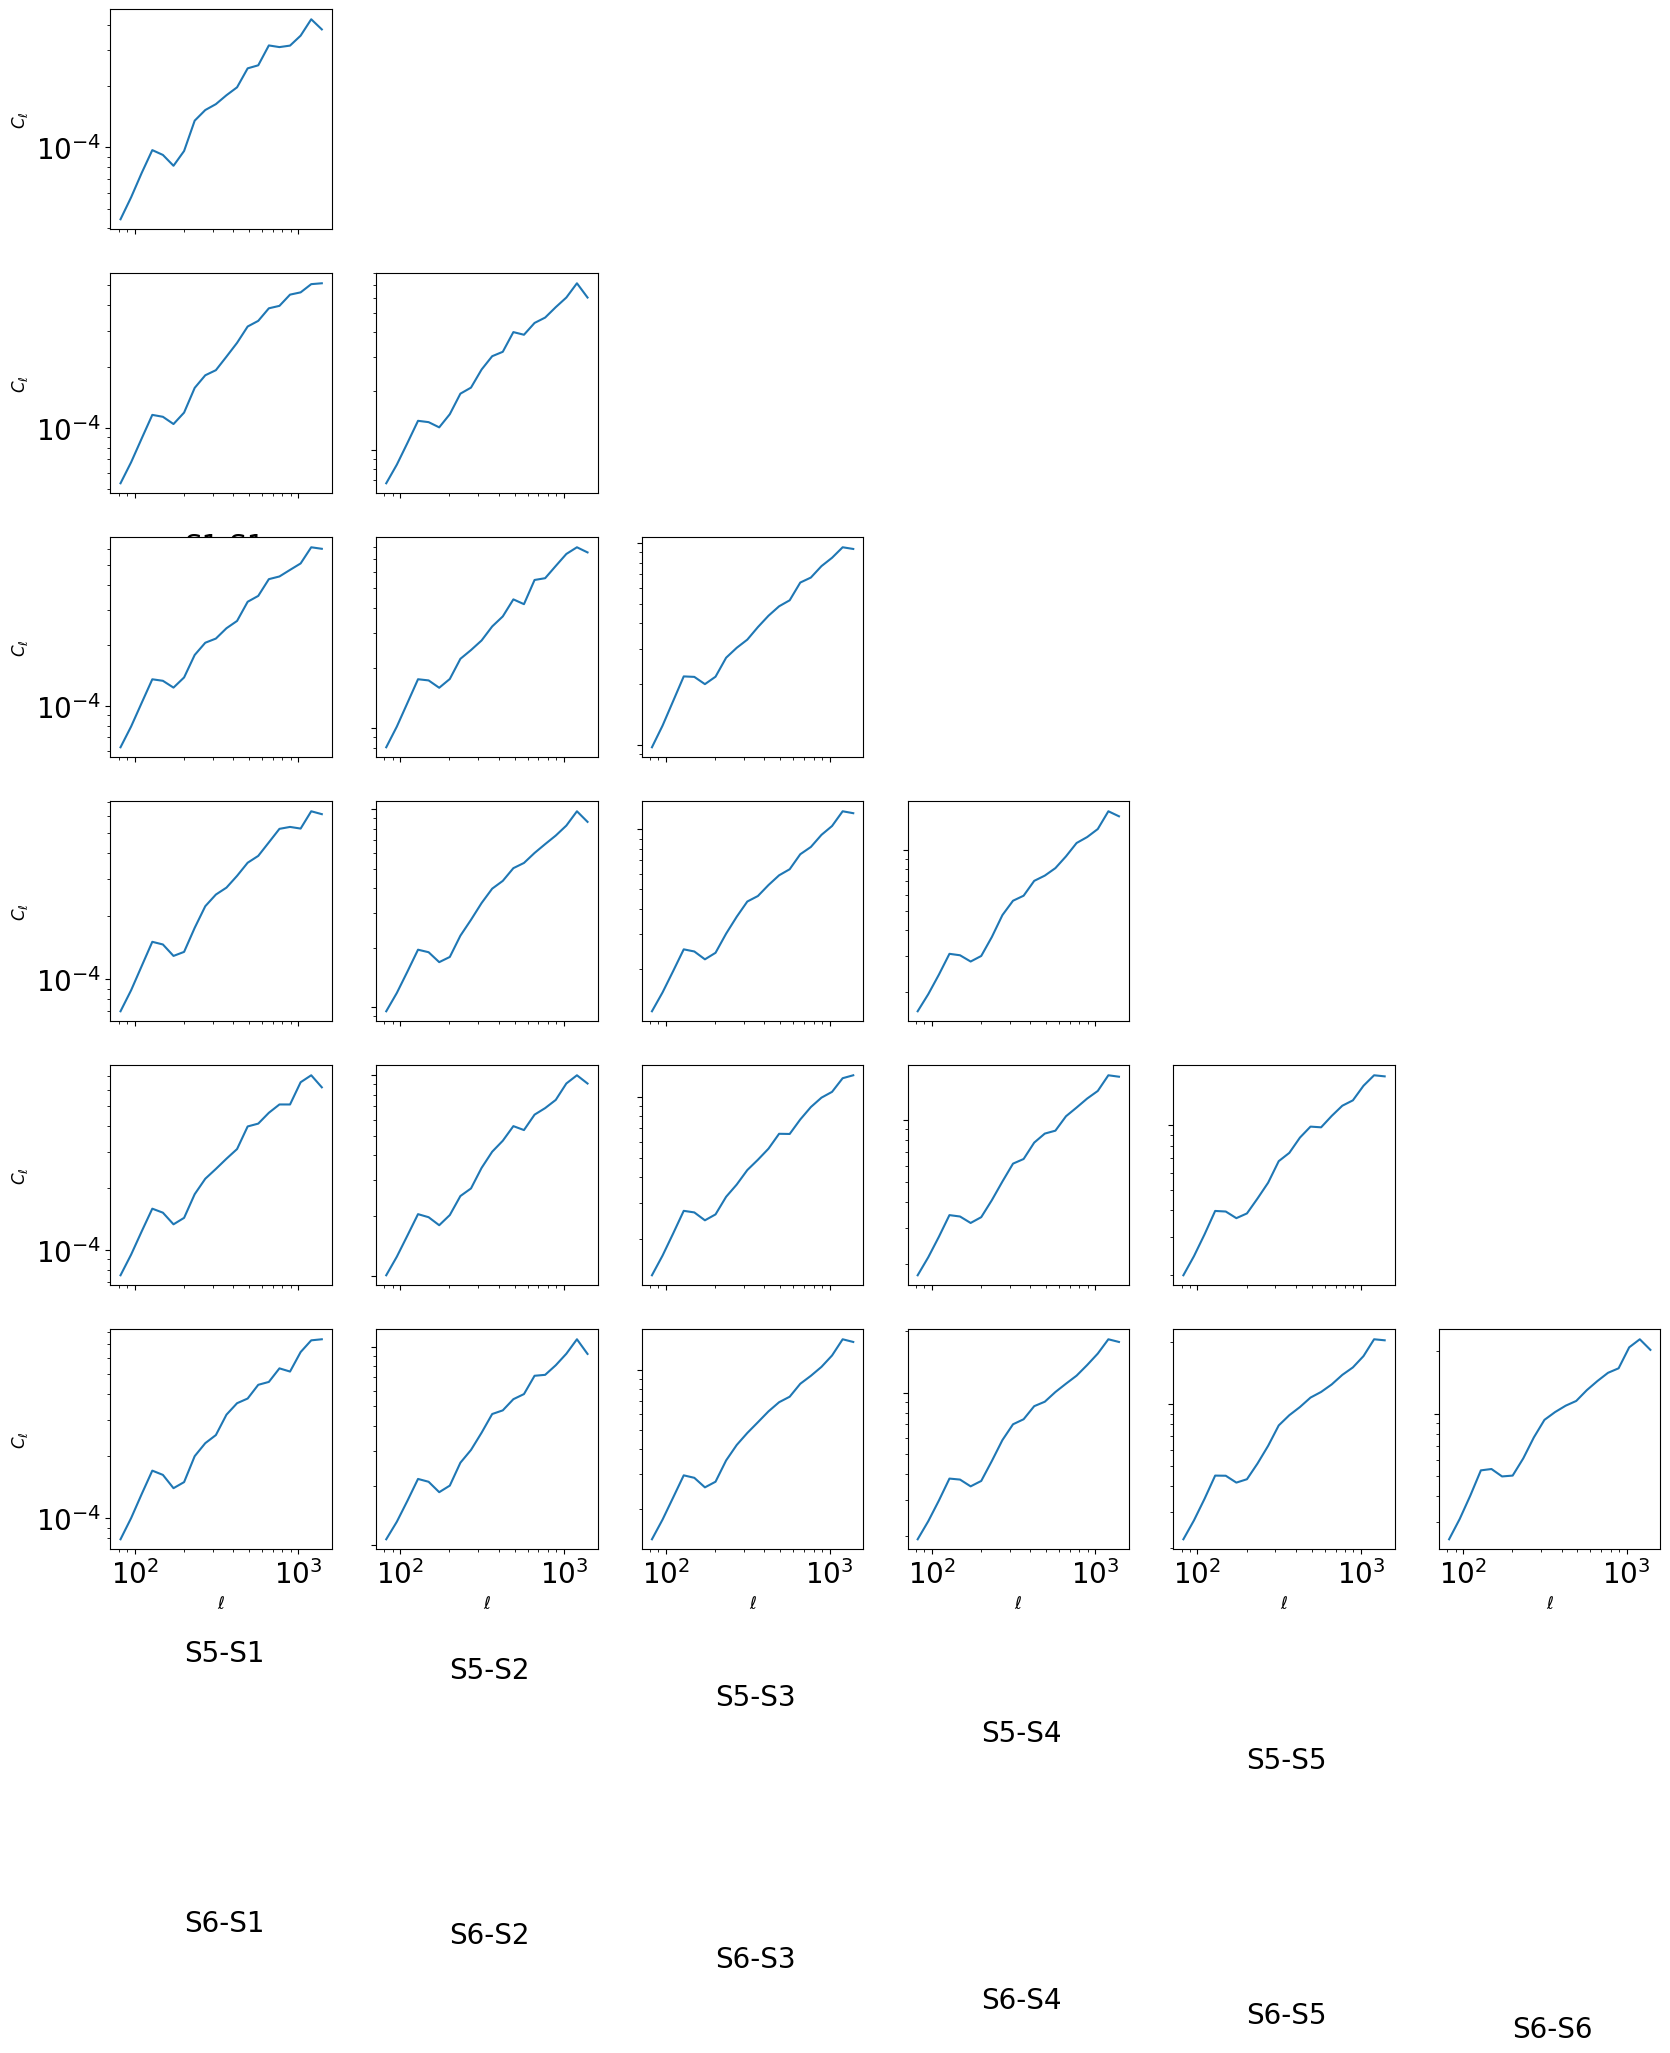

In [20]:
for cl_type, cl_results in cls_results.items():
    print(cl_type)
    cll_bands = cl_results['bandpower_ls']
    bandpowers = cl_results["bandpowers"]
    fig, ax = plt.subplots(nbins, nbins, figsize=(20,20))
    for i in range(nbins):
        for j in range(nbins):
            if i<j:
                ax[i, j].axis('off')
            else:
                label = 'S'+str(i+1)+'-S'+str(j+1)
                ax[i, j].plot(cll_bands, bandpowers[int(i*(i+1)/2 + j)], label=label)
                ax[i, j].set_xscale('log')
                ax[i, j].set_yscale('log')
                # ax[i, j].set_xlim([lower_lscale, upper_lscale])
                # ax[i, j].set_ylim([5e-14, 5e-6])
                ax[i, j].text(200, 1e-6, label)

                if i == nbins - 1:
                    ax[i, j].set_xlabel(r'$\ell$', fontsize=12)
                else:
                    plt.setp(ax[i, j].get_xticklabels(), visible=False)
                
                if j == 0:
                    ax[i, j].set_ylabel(r'$C_{\ell}$', fontsize=12)
                else:
                    plt.setp(ax[i, j].get_yticklabels(), visible=False)
    plt.show()